In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import unicodedata
import re
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm

## Data Processing

In [2]:
train_texts = pd.read_csv('data/train_texts.txt', header=None)
train_labels = pd.read_csv('data/train_labels.txt', header=None)
train_texts.head()

,0
0,Wall St. Bears Claw Back Into the Black (Reute...
1,Carlyle Looks Toward Commercial Aerospace (Reu...
2,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,Iraq Halts Oil Exports from Main Southern Pipe...
4,Oil prices soar to all-time record posing new...


In [3]:
len(train_texts), len(train_labels)

(120000, 120000)

In [14]:
train_text_list = list(train_texts[0])
train_text_list = [line.lower() for line in train_text_list]

In [5]:
train_df = pd.read_csv('archive/train.csv')
test_df = pd.read_csv('archive/test.csv')
train_df.head(17)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
5,3,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...
6,3,Money Funds Fell in Latest Week (AP),AP - Assets of the nation's retail money marke...
7,3,Fed minutes show dissent over inflation (USATO...,USATODAY.com - Retail sales bounced back a bit...
8,3,Safety Net (Forbes.com),Forbes.com - After earning a PH.D. in Sociolog...
9,3,Wall St. Bears Claw Back Into the Black,"NEW YORK (Reuters) - Short-sellers, Wall Stre..."


In [6]:
train_text_list[16]

'kids rule for back-to-school the purchasing power of kids is a big part of why the back-to-school season has become such a huge marketing phenomenon.'

In [7]:
test_df.head()

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [31]:
labels, news = list(train_df['Class Index']), list(train_df['Description'])

In [32]:
for i in range(len(news)):
    news[i] = news[i].lower()
    
    if " - " in news[i]:
        hyphen_idx = news[i].index(' - ')
        news[i] = news[i][hyphen_idx + 3:]
    
    news[i] = news[i].replace('.', '')
    news[i] = news[i].replace('-', ' ') # replace hiphens with spaces
    news[i] = news[i].replace('\\', ' ') # replace \\ with spaces
    news[i] = unicodedata.normalize('NFD', news[i])
    news[i] = re.sub('\d', '0', news[i])
    news[i] = re.sub('[^a-z0 ]', '', news[i])
    news[i] = news[i].split()

In [35]:
news[20]

['the',
 'bidding',
 'gets',
 'underway',
 'for',
 'googles',
 'public',
 'offering',
 'despite',
 'last',
 'minute',
 'worries',
 'over',
 'an',
 'interview',
 'with',
 'its',
 'bosses',
 'in',
 'playboy',
 'magazine']

In [40]:
vocabs = []
for l in news:
    vocabs += l
    
vocabs = list(set(vocabs))

In [44]:
vocab_size = len(vocabs)
vocab_size

64730

In [58]:
vocabs_dict = {}
for i in range(len(vocabs)):
    vocabs_dict[vocabs[i]] = vocabs_dict.setdefault(vocabs[i], i)

##### Cleaning test set

In [164]:
test_labels, test_news = list(test_df['Class Index']), list(test_df['Description'])

In [165]:
for i in range(len(test_news)):
    test_news[i] = test_news[i].lower()
    
    if " - " in test_news[i]:
        hyphen_idx = test_news[i].index(' - ')
        test_news[i] = test_news[i][hyphen_idx + 3:]
    
    test_news[i] = test_news[i].replace('.', '')
    test_news[i] = test_news[i].replace('-', ' ') # replace hiphens with spaces
    test_news[i] = test_news[i].replace('\\', ' ') # replace \\ with spaces
    test_news[i] = unicodedata.normalize('NFD', test_news[i])
    test_news[i] = re.sub('\d', '0', test_news[i])
    test_news[i] = re.sub('[^a-z0 ]', '', test_news[i])
    test_news[i] = test_news[i].split()
    test_news[i] = [word for word in test_news[i] if word in vocabs_dict]

In [166]:
test_news

[['unions',
  'representing',
  'workers',
  'at',
  'turner',
  'newall',
  'say',
  'they',
  'are',
  'disappointed',
  'after',
  'talks',
  'with',
  'stricken',
  'parent',
  'firm',
  'federal',
  'mogul'],
 ['toronto',
  'canada',
  'a',
  'second',
  'team',
  'of',
  'rocketeers',
  'competing',
  'for',
  'the',
  '0000',
  'million',
  'ansari',
  'x',
  'prize',
  'a',
  'contest',
  'for',
  'privately',
  'funded',
  'suborbital',
  'space',
  'flight',
  'has',
  'officially',
  'announced',
  'the',
  'first',
  'launch',
  'date',
  'for',
  'its',
  'manned',
  'rocket'],
 ['a',
  'company',
  'founded',
  'by',
  'a',
  'chemistry',
  'researcher',
  'at',
  'the',
  'university',
  'of',
  'louisville',
  'won',
  'a',
  'grant',
  'to',
  'develop',
  'a',
  'method',
  'of',
  'producing',
  'better',
  'peptides',
  'which',
  'are',
  'short',
  'chains',
  'of',
  'amino',
  'acids',
  'the',
  'building',
  'blocks',
  'of',
  'proteins'],
 ['its',
  'barely'

## Word Embedding

In [42]:
co_occurences = {}
for w in news:
    for i in range(len(w)-2):
        co_occurences[(w[i+1], w[i])] = co_occurences.setdefault((w[i+1], w[i]), 0) + 1
        co_occurences[(w[i+1], w[i+2])] = co_occurences.setdefault((w[i+1], w[i]), 0) + 1

In [56]:
len(co_occurences)

1602234

In [65]:
co_pairs = []
for k in list(co_occurences.keys()):
    co_pairs.append([vocabs_dict[k[0]], vocabs_dict[k[1]], co_occurences[k]])

In [47]:
co_occurences

{('sellers', 'short'): 2,
 ('sellers', 'wall'): 3,
 ('wall', 'sellers'): 2,
 ('wall', 'streets'): 8,
 ('streets', 'wall'): 65,
 ('streets', 'dwindling'): 3,
 ('dwindling', 'streets'): 2,
 ('dwindling', 'band'): 3,
 ('band', 'dwindling'): 2,
 ('band', 'of'): 2,
 ('of', 'band'): 27,
 ('of', 'ultra'): 3,
 ('ultra', 'of'): 2,
 ('ultra', 'cynics'): 3,
 ('cynics', 'ultra'): 2,
 ('cynics', 'are'): 3,
 ('are', 'cynics'): 2,
 ('are', 'seeing'): 4,
 ('seeing', 'are'): 9,
 ('seeing', 'green'): 2,
 ('green', 'seeing'): 3,
 ('green', 'again'): 3,
 ('investment', 'private'): 15,
 ('investment', 'firm'): 2,
 ('firm', 'investment'): 21,
 ('firm', 'carlyle'): 2,
 ('carlyle', 'firm'): 1,
 ('carlyle', 'group'): 3,
 ('group', 'carlyle'): 8,
 ('group', 'which'): 8,
 ('which', 'group'): 37,
 ('which', 'has'): 12,
 ('has', 'which'): 310,
 ('has', 'a'): 6,
 ('a', 'has'): 165,
 ('a', 'reputation'): 391,
 ('reputation', 'a'): 26,
 ('reputation', 'for'): 2,
 ('for', 'reputation'): 18,
 ('for', 'making'): 15,
 ('

In [87]:
class GloVe(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.weight_o = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_size,
            sparse=False
        )
        
        self.weight_c = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_size,
            sparse=False
        )
        
        self.bias_o = nn.Parameter(
            torch.randn(vocab_size, dtype=torch.float)
        )
        
        self.bias_c = nn.Parameter(
            torch.randn(vocab_size, dtype=torch.float)
        )
        
        self.h = lambda x: ((x / 100)**0.75).clamp(0, 1)

    def forward(self, i, j, x):
        uv = torch.mul(self.weight_c(i), self.weight_o(j)).sum(dim=1)
        loss = (uv + self.bias_c[i] + self.bias_o[j] - x.log()).square()
        loss = torch.mul(self.h(x), loss).sum()
        return loss

In [74]:
co_pairs_tensor = TensorDataset(torch.tensor(co_pairs))
co_pairs_dataloader = DataLoader(co_pairs_tensor, batch_size=1000)

In [103]:
model = GloVe(vocab_size, 100)
optimizer = torch.optim.Adagrad(
    model.parameters(),
    lr = 0.01
)

In [104]:
model.train()
losses = []
for epoch in range(5):
    epoch_loss = 0.0
    running_loss = 0.0
    for i, data in enumerate(co_pairs_dataloader, 0):
        
        optimizer.zero_grad()
        
        loss = model(data[0][:, 0], data[0][:, 1], data[0][:, 2])
        
        epoch_loss += loss.item()
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        
        if i % 100 == 99:  
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0
            
    losses.append(epoch_loss)

[1,   100] loss: 29638.241
[1,   200] loss: 22446.785
[1,   300] loss: 19349.315
[1,   400] loss: 17293.147
[1,   500] loss: 17297.684
[1,   600] loss: 16656.561
[1,   700] loss: 16513.364
[1,   800] loss: 16183.387
[1,   900] loss: 16153.335
[1,  1000] loss: 16277.541
[1,  1100] loss: 16398.512
[1,  1200] loss: 16836.729
[1,  1300] loss: 16310.808
[1,  1400] loss: 16385.812
[1,  1500] loss: 16287.897
[1,  1600] loss: 16710.409
[2,   100] loss: 23623.821
[2,   200] loss: 18786.502
[2,   300] loss: 16491.720
[2,   400] loss: 14906.759
[2,   500] loss: 15046.011
[2,   600] loss: 14590.200
[2,   700] loss: 14560.900
[2,   800] loss: 14311.869
[2,   900] loss: 14334.784
[2,  1000] loss: 14503.148
[2,  1100] loss: 14649.032
[2,  1200] loss: 15082.664
[2,  1300] loss: 14645.387
[2,  1400] loss: 14743.027
[2,  1500] loss: 14681.204
[2,  1600] loss: 15099.237
[3,   100] loss: 21456.074
[3,   200] loss: 17192.524
[3,   300] loss: 15151.324
[3,   400] loss: 13735.645
[3,   500] loss: 13893.200
[

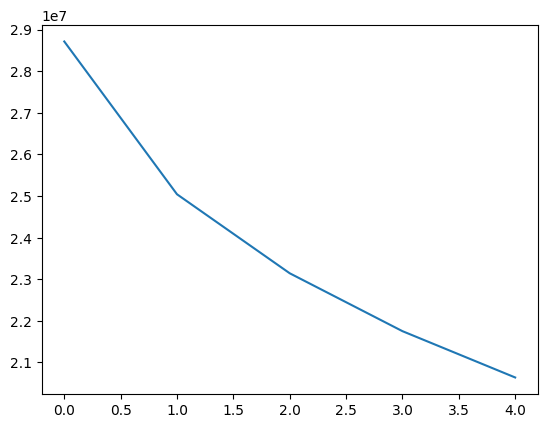

In [105]:
plt.plot(losses)

In [109]:
u = model.weight_c.weight.detach().numpy()
u_reduces = TSNE(2).fit_transform(u)

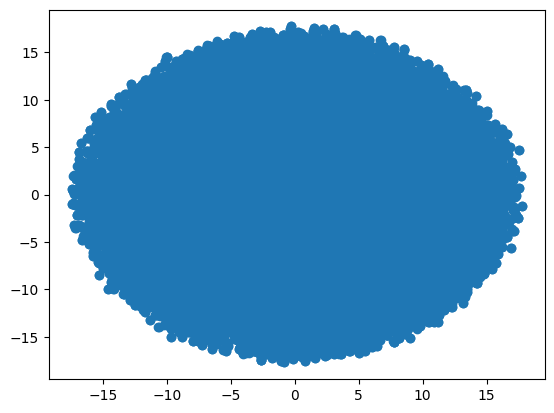

In [112]:
plt.scatter(u_reduces[:,0], u_reduces[:,1]);

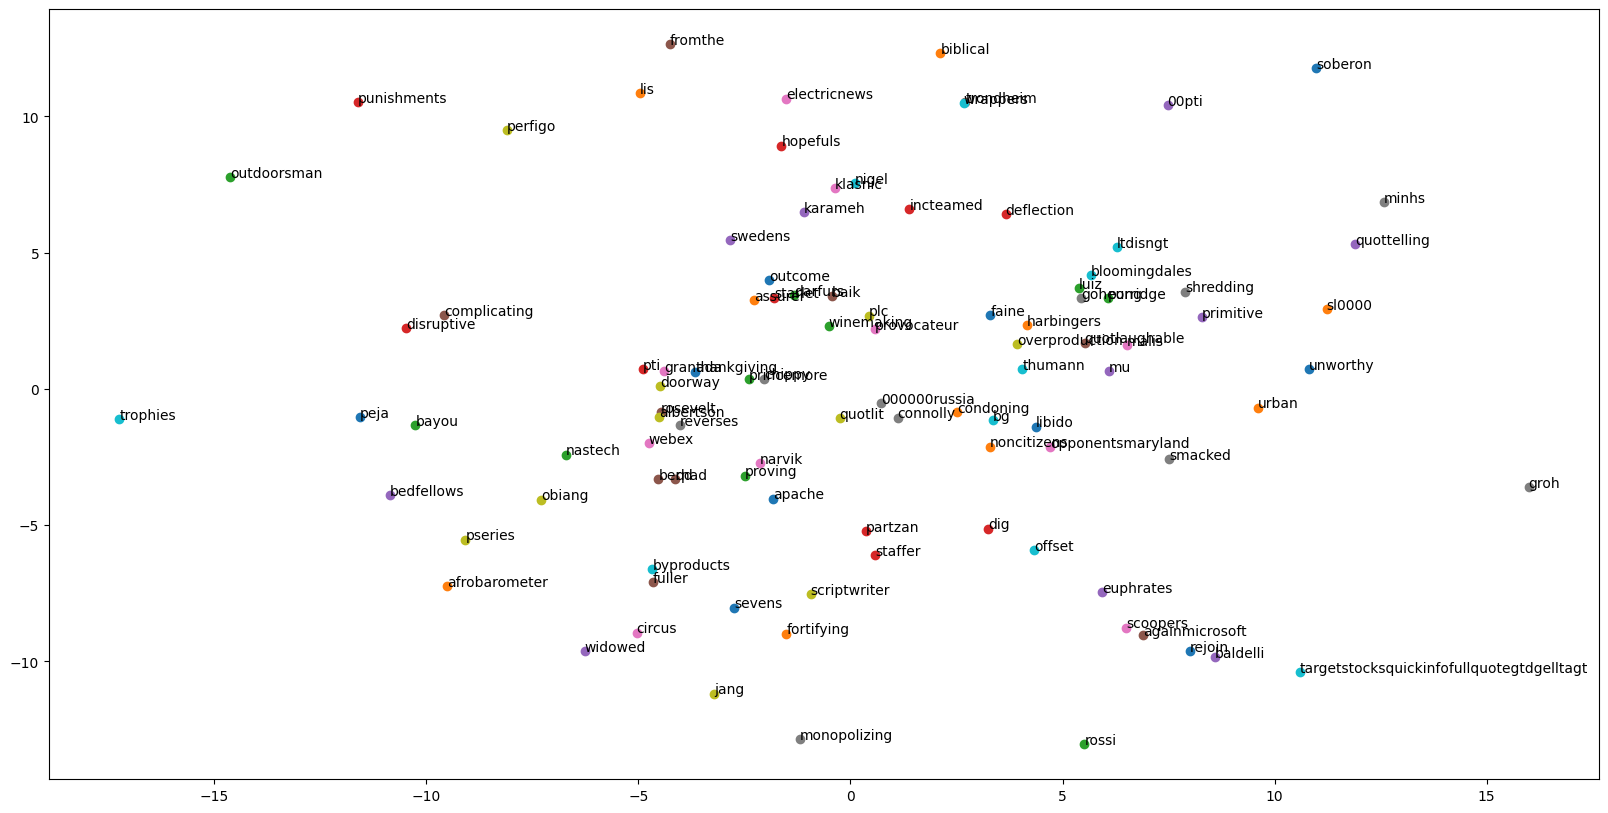

In [118]:
selected_indices = np.random.choice(list(range(vocab_size)), 100)
selected_vocabs = np.asarray(vocabs)[selected_indices]
selected_embed = np.asarray(u_reduces)[selected_indices]
    
fig, ax = plt.subplots(figsize=(20, 10))
    
for i in range(len(selected_embed)):
    ax.scatter(selected_embed[i][0], selected_embed[i][1], label=selected_vocabs[i]);
    
for i, name in enumerate(selected_vocabs):
    ax.annotate(name, (selected_embed[i][0], selected_embed[i][1]))

#plt.axvline(x = 0, color='black', linestyle='dashed');
#plt.axhline(y = 0, color='black', linestyle='dashed');

In [203]:
vocabs_dict["medal"]

61247

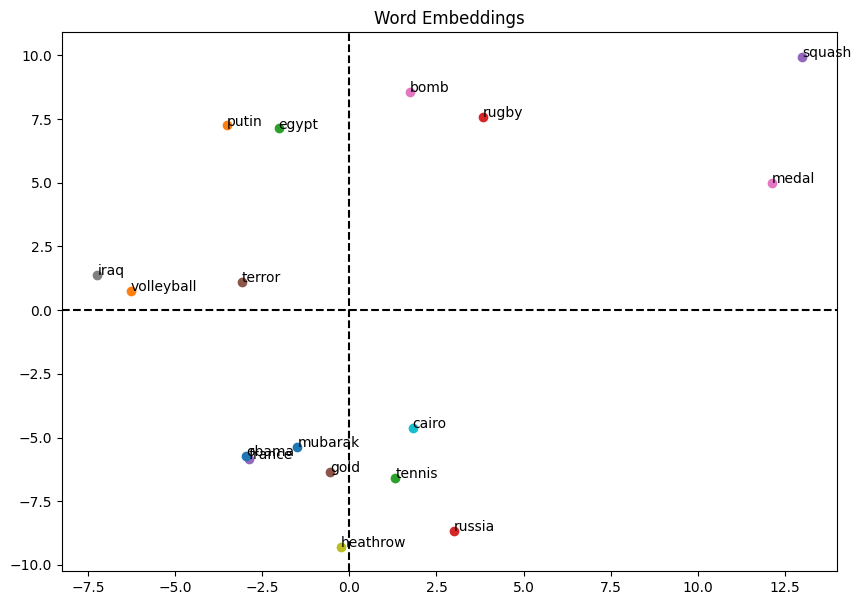

In [208]:
selected_indices = np.asarray([51636, 52846, 37594, 36233, 19524, 9061, 9340, 35732, 14161, 7417, 52199,
                              8965, 48433, 33871, 2376, 4148, 61247])
selected_vocabs = np.asarray(vocabs)[selected_indices]
selected_embed = np.asarray(u_reduces)[selected_indices]
    
fig, ax = plt.subplots(figsize=(10, 7))
    
for i in range(len(selected_embed)):
    ax.scatter(selected_embed[i][0], selected_embed[i][1], label=selected_vocabs[i]);
    
for i, name in enumerate(selected_vocabs):
    ax.annotate(name, (selected_embed[i][0], selected_embed[i][1]))

plt.axvline(x = 0, color='black', linestyle='dashed');
plt.axhline(y = 0, color='black', linestyle='dashed');
plt.title("Word Embeddings"); plt.show()

In [211]:
np.linalg.norm(u[33871] - u[61247])

12.563936

## Part 2 - Text Classification

In [182]:
i = 0
for sentence in news:
    if (len(sentence) == 0):
        print(i, sentence)
        
    i += 1

115481 []


In [170]:
sentence_embed = []
for sentence in news:
    w_sentence = np.zeros(100)
    for word in sentence:
        word_idx = vocabs_dict[word]
        w_sentence += u[word_idx]
    
    if(len(sentence) != 0):
        sentence_embed.append(w_sentence / len(sentence))
    else:
        sentence_embed.append(w_sentence)

In [171]:
sentence_embed = np.asarray(sentence_embed)

In [135]:
class CustomDataset(Dataset):
    def __init__(self, embeddings, labels, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.embeddings = embeddings
        self.labels = np.asarray(labels)
        self.transform = transform
        
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [172]:
training_set = CustomDataset(sentence_embed, labels)
trainloader = DataLoader(training_set, batch_size = 100)

In [173]:
classifier = nn.Sequential(
    nn.Linear(100, 1000),
    nn.ReLU(),
    nn.Linear(1000, 2000),
    nn.ReLU(),
    nn.Linear(2000, 4)
)

In [174]:
optimizer = torch.optim.Adam(
    classifier.parameters(),
)

criterion = nn.CrossEntropyLoss()

In [175]:
classifier.train()
losses = []
for epoch in range(5):
    epoch_loss = 0.0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        embeds, label = data
        embeds = embeds.to(torch.float32)
        label = label - 1
        label = label.to(torch.long)
        
        optimizer.zero_grad()
        
        output = classifier(embeds)
        
        loss = criterion(output, label)
        
        epoch_loss += loss.item()
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        
        if i % 100 == 99:  
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0
            
    losses.append(epoch_loss)

[1,   100] loss: 1.373
[1,   200] loss: 1.158
[1,   300] loss: 1.111
[1,   400] loss: 1.091
[1,   500] loss: 1.055
[1,   600] loss: 1.038
[1,   700] loss: 1.003
[1,   800] loss: 0.984
[1,   900] loss: 0.991
[1,  1000] loss: 0.985
[1,  1100] loss: 0.991
[1,  1200] loss: 0.968
[2,   100] loss: 0.960
[2,   200] loss: 0.917
[2,   300] loss: 0.886
[2,   400] loss: 0.886
[2,   500] loss: 0.859
[2,   600] loss: 0.862
[2,   700] loss: 0.826
[2,   800] loss: 0.796
[2,   900] loss: 0.816
[2,  1000] loss: 0.840
[2,  1100] loss: 0.839
[2,  1200] loss: 0.822
[3,   100] loss: 0.843
[3,   200] loss: 0.801
[3,   300] loss: 0.768
[3,   400] loss: 0.772
[3,   500] loss: 0.749
[3,   600] loss: 0.760
[3,   700] loss: 0.725
[3,   800] loss: 0.691
[3,   900] loss: 0.714
[3,  1000] loss: 0.747
[3,  1100] loss: 0.741
[3,  1200] loss: 0.721


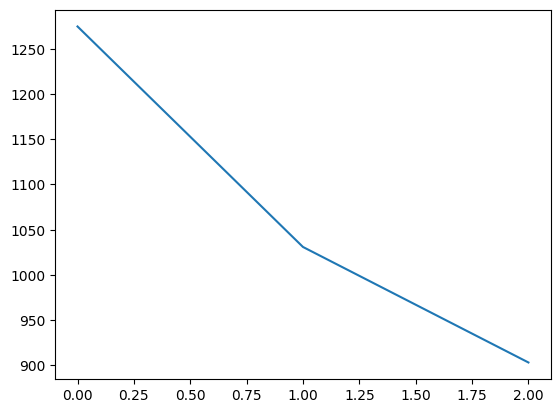

In [176]:
plt.plot(losses)

In [177]:
sentence_embed_tensor = torch.tensor(sentence_embed)
sentence_embed_tensor = sentence_embed_tensor.to(torch.float32)
predicted_train_labels = classifier(sentence_embed_tensor)

In [178]:
predicted_train_labels_mod = np.argmax(predicted_train_labels.detach().numpy(), axis=1)
predicted_train_labels_mod += 1

In [179]:
np.mean(predicted_train_labels_mod == np.asarray(labels))

0.7323333333333333

In [180]:
# Test sentences embedding
test_sentence_embed = []
for sentence in test_news:
    w_sentence = np.zeros(100)
    for word in sentence:
        word_idx = vocabs_dict[word]
        w_sentence += u[word_idx]
    
    test_sentence_embed.append(w_sentence)

In [181]:
test_sentence_embed = np.asarray(test_sentence_embed)
test_sentence_embed_tensor = torch.tensor(test_sentence_embed)
test_sentence_embed_tensor = test_sentence_embed_tensor.to(torch.float32)
predicted_test_labels = classifier(test_sentence_embed_tensor)

predicted_test_labels_mod = np.argmax(predicted_test_labels.detach().numpy(), axis=1)
predicted_test_labels_mod += 1

np.mean(predicted_test_labels_mod == np.asarray(test_labels))

0.5481578947368421